## Final constraints in the physical parameters $m_\phi/m_4 = 0.5$

https://github.com/mhostert/solar-neutrino-visible-decays

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from scipy.stats import chi2
import importlib
import vegas
import gvar as gv

from source import *
from source import flavour_transitions as osc
from source.plot_tools import *


## Pick points to sample integrand

In [3]:
##########
# integration evaluations
rates.NEVALwarmup = 1e3
rates.NEVAL = 1e5

## Flux and Decay Parameters

The mixings will be used to rescale the number of events, so pick anything sensible

In [7]:
###########
# NUMU FLUX
fluxfile = "fluxes/b8spectrum.txt"
flux = fluxes.get_neutrino_flux(fluxfile)

###########
# DECAY MODEL PARAMETERS
params = model.decay_model_params(const.SCALAR)
params.gx		= 1.0
params.Ue4		= np.sqrt(0.01)
params.Umu4		= np.sqrt(0.01)
params.Utau4    = np.sqrt(0)
params.UD4		= np.sqrt(1.0-params.Ue4*params.Ue4-params.Umu4*params.Umu4)
params.m4		= 100e-9 # GeV
params.mBOSON  = 0.5*params.m4 # GeV

###########
# EXPERIMENTS
KAM21 = exps.kamland21_data()
KAM = exps.kamland_data()
BOR = exps.borexino_data()
SK = exps.superk_data()


# Compute rates for benchmark point at the three experiments

This can be an expensive computation, depending on the desired precision -- we care about tails.

In [8]:
UE4SQR, UMU4SQR, LK21 = stats.get_likelihood(KAM21, params, fluxfile, endpoint=18.31, NPOINTS =33)
UE4SQR, UMU4SQR, LK = stats.get_likelihood(KAM, params, fluxfile, endpoint=16.3, NPOINTS =33)
UE4SQR, UMU4SQR, LB = stats.get_likelihood(BOR, params, fluxfile, endpoint=16.3, NPOINTS =33)
UE4SQR, UMU4SQR, LS = stats.get_likelihood(SK, params, fluxfile, endpoint=16.3, NPOINTS =33)

Filling the bins in kamland21
1.2321386487235222 3
Filling the bins in kamland
5.14696624163787 6
Filling the bins in borexino
19.739876035592072 12
Filling the bins in SUPERK_IV
2.2760395325135008 2


In [360]:
uesqr = 1e-4
new_factorK = uesqr * osc.Pse_spline_nubar(bK, uesqr, 0.005)
new_factorS = uesqr * osc.Pse_spline_nubar(bS, uesqr, 0.005)
np_newK = new_factorK / old_factorK * npK
np_newS = new_factorS / old_factorS * npS
print(stats.chi2_binned_rate(np_newK, backK, dK, [err_flux, err_backK]) - np.min(LK))
print(stats.chi2_binned_rate(np_newS, backS, dS, [2*err_flux, 2*err_backS]) - np.min(LS))

3.0105565349051204
2.2760395325135008


# Plot resulting limits

### Setup and plot preference regions from https://arxiv.org/abs/1911.01427 

<ipython-input-17-c43006bedf7b>:65: UserWarning: The following kwargs were not used by contour: 'ls', 'label'
  c2=ax.contour(X,Y,LS, [chi2.ppf(0.99, 2)], linestyles=['--'],colors=['dodgerblue'],linewidths=[1.0], ls='--',label=r'SuperK-IV')
<ipython-input-17-c43006bedf7b>:66: UserWarning: The following kwargs were not used by contour: 'label'
  c3=ax.contour(X,Y,LB, [chi2.ppf(0.99, 12)], linestyles=['--'],colors=['indigo'],linewidths=[1.0],label=r'Borexino')
<ipython-input-17-c43006bedf7b>:67: UserWarning: The following kwargs were not used by contour: 'label'
  c1=ax.contour(X,Y,LK, [chi2.ppf(0.99, 6)], linestyles=['--'],colors=['forestgreen'],linewidths=[1.0],label=r'KamLAND 2011')
<ipython-input-17-c43006bedf7b>:68: UserWarning: The following kwargs were not used by contour: 'label'
  c4=ax.contour(X,Y,LK21, [chi2.ppf(0.99, 3)], linestyles=['-'],colors=['magenta'],linewidths=[1.0],label=r'KamLAND 2021')
<ipython-input-17-c43006bedf7b>:122: UserWarning: Matplotlib is currently using 

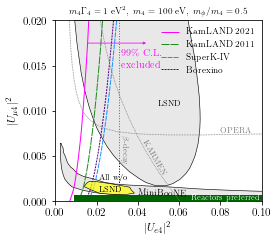

In [17]:
################################################################
# PLOTTING THE LIMITS
################################################################
fsize=11
rc('text', usetex=True)
rcparams={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
				'figure.figsize':(1*3.7,1.4*2.3617)	}
rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
matplotlib.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth
rcParams.update(rcparams)
axes_form  = [0.185,0.15,0.775,0.76]
fig = plt.figure()
ax = fig.add_axes(axes_form)
matplotlib.rcParams['hatch.linewidth'] = 1  # previous pdf hatch linewidth

############
# GET THE FIT REGIONS FROM DENTLER ET AL
DentlerPath='digitized/Dentler_et_al/0.5_100/'

SB_COLOR = 'lightgrey'
MB_ue_b,MB_umu_b = np.genfromtxt(DentlerPath+'bottom_MiniBooNE.dat',unpack=True)
MB_ue_t,MB_umu_t = np.genfromtxt(DentlerPath+'top_MiniBooNE.dat',unpack=True)
MB_ue_f=np.logspace( np.log10(np.min([MB_ue_b])), np.log10(np.max([MB_ue_b])), 100)
MB_umu_b_f = np.interp(MB_ue_f,MB_ue_b,MB_umu_b)
MB_umu_t_f = np.interp(MB_ue_f,MB_ue_t,MB_umu_t)
ax.fill_between(MB_ue_f,MB_umu_b_f,MB_umu_t_f,facecolor=SB_COLOR,alpha=0.5,lw=0)
ax.fill_between(MB_ue_f,MB_umu_b_f,MB_umu_t_f,edgecolor='black',facecolor='None',lw=0.6)

y,x = np.genfromtxt(DentlerPath+'right_LSND.dat',unpack=True)
yl,xl = np.genfromtxt(DentlerPath+'left_LSND.dat',unpack=True)
x_f=np.logspace( np.log10(np.min([x])), np.log10(np.max([x])), 100)
y_f = np.interp(x_f,x,y)
yl_f = np.interp(x_f,xl,yl)
ax.fill_betweenx(x_f,y_f,yl_f,facecolor=SB_COLOR,alpha=0.5,lw=0)
ax.fill_betweenx(x_f,y_f,yl_f,edgecolor='black',facecolor='None',lw=0.6)

x,y = np.genfromtxt(DentlerPath+'bottom_combined.dat',unpack=True)
xl,yl = np.genfromtxt(DentlerPath+'top_combined.dat',unpack=True)
x_f=np.logspace( np.log10(np.min([x])), np.log10(np.max([x])), 100)
y_f = np.interp(x_f,x,y)
yl_f = np.interp(x_f,xl,yl)
ax.fill_between(x_f,y_f,yl_f,facecolor='None',edgecolor='yellow',
                hatch='/////////////////////////////////////////',alpha=0.7,lw=0,zorder=10)
ax.fill_between(x_f,y_f,yl_f,edgecolor='black',facecolor='None',lw=0.6,zorder=10)


x,y = np.genfromtxt(DentlerPath+'KARMEN.dat',unpack=True)
ax.plot(x,y,lw=0.8,color='gray',dashes=(1,1))
x,y = np.genfromtxt(DentlerPath+'OPERA.dat',unpack=True)
ax.plot(x,y,lw=0.8,color='gray',dashes=(1,1))


X,Y = np.meshgrid(UE4SQR,UMU4SQR)
# ax.contourf(X,Y,LK, [chi2.ppf(0.90, dofK),1e100], colors=['black'],alpha=0.1, linewidths=[0.1])
# ax.contour(X,Y,L, 20, color='black')

# ax.contourf(X,Y,LB, [chi2.ppf(0.90, dofB),1e100], colors=['black'],alpha=0.1, linewidths=[0.1])

# Z = LB
# pcm = ax.pcolor(X, Y, Z,
#                    norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
#                    cmap='PuBu_r')# ax.contour(X,Y,L, 20, color='black')
# fig.colorbar(pcm, ax=ax, extend='max')

c2=ax.contour(X,Y,LS, [chi2.ppf(0.99, 2)], linestyles=['--'],colors=['dodgerblue'],linewidths=[1.0], ls='--',label=r'SuperK-IV')
c3=ax.contour(X,Y,LB, [chi2.ppf(0.99, 12)], linestyles=['--'],colors=['indigo'],linewidths=[1.0],label=r'Borexino')
c1=ax.contour(X,Y,LK, [chi2.ppf(0.99, 6)], linestyles=['--'],colors=['forestgreen'],linewidths=[1.0],label=r'KamLAND 2011')
c4=ax.contour(X,Y,LK21, [chi2.ppf(0.99, 3)], linestyles=['-'],colors=['magenta'],linewidths=[1.0],label=r'KamLAND 2021')
c2.collections[0].set_dashes([(0, (5.0, 1.0))])
c3.collections[0].set_dashes([(0, (2.0, 1.0))])
c1.collections[0].set_dashes([(0, (8.0, 1.0))])
h1,_ = c1.legend_elements()
h2,_ = c2.legend_elements()
h3,_ = c3.legend_elements()
h4,_ = c4.legend_elements()
ax.legend([h4[0], h1[0], h2[0],h3[0]], ['KamLAND 2021', 'KamLAND 2011', 'SuperK-IV','Borexino',],loc='upper right', frameon=False,fontsize=9)

# ax.clear()
# ax.set_xscale('log')
# ax.set_yscale('log')
##############
# STYLE
if params.model == const.VECTOR:
    boson_string = r'$m_{Z^\prime}$'
    boson_file = 'vector'
elif params.model == const.SCALAR:
    boson_string = r'$m_\phi$'
    boson_file = 'scalar'

ax.set_title(r'$m_4 \Gamma_4 = 1$ eV$^2$,\, $m_4 = %.0f$ eV,\, '%(params.m4*1e9)+boson_string+r'$/m_4 = %.1f$'%(params.mBOSON/params.m4), fontsize=9)
ax.annotate(r'MiniBooNE',xy=(0.4,0.031),xycoords='axes fraction',color='black',fontsize=9,rotation=-2)
ax.annotate(r'LSND',xy=(0.5,0.53),xycoords='axes fraction',color='black',fontsize=8,rotation=0)
ax.annotate(r'\noindent All w/o \\LSND',xy=(0.21,0.12),xycoords='axes fraction',color='black',fontsize=8,rotation=0,zorder=10)

ax.annotate(r'\noindent 99\% C.L. \\\noindent excluded', 
            fontsize=0.9*fsize, xy=(1.2,0.2), xytext=(0.32,0.8),xycoords='axes fraction', color='magenta')

ax.fill_between(np.linspace(9e-3,0.1,100),0.7e-3*np.ones(100),-0.05e-3*np.ones(100),
                lw=0.0,fc='None',ec='darkgreen',
                hatch='//////////////////////////////////////',zorder=2)
ax.annotate(r'Reactors preferred',xy=(0.066,0.13e-3),
                xycoords='data',color='white',fontsize=7.5,rotation=0)
ax.vlines(0.031,-1,1,lw=1.0, ls=':',color='black',zorder=-1)
ax.annotate(r'OPERA',xy=(0.08,0.0076), 
            xycoords='data',color='grey',fontsize=8,rotation=0)
ax.annotate(r'KARMEN',xy=(0.042,0.0030), 
            xycoords='data',color='grey',fontsize=8,rotation=-60)
ax.annotate(r'$\beta$-decay',xy=(0.032,0.0043), 
            xycoords='data',color='grey',fontsize=8,rotation=-90)


ax.annotate(r'', fontsize=fsize, xy=(0.045,0.0175), xytext=(0.015,0.0175), xycoords='data' ,zorder=1000, color='magenta',
arrowprops=dict(arrowstyle="-|>", mutation_scale=5, color='magenta', lw = 0.8))

ax.set_xlim(0,0.1)
ax.set_ylim(0,0.02)
ax.set_yticks([0,0.005,0.01,0.015,0.02])
ax.set_xlabel(r'$|U_{e 4}|^2$')
ax.set_ylabel(r'$|U_{\mu 4}|^2$')
fig.savefig('plots/limits_MN_%.0f_MB_%.0f.pdf'%(params.m4*1e9,params.mBOSON*1e9))
fig.savefig('plots/limits_MN_%.0f_MB_%.0f.png'%(params.m4*1e9,params.mBOSON*1e9))
fig.show()
